# NBA Scores
**ML Project 1 - Spring 2022**

Collaborators: Ben DeSollar and Matt McDonell


Descriptions: The first part should be a description which models/classifiers/regressors achieved the best 
    results with your datasets datasets, and what you did to improve those results along the way.

    - Through research we found that a called GradientBoostingRegressor worked the best after testing a couple different model including
    KNeighborsRegressor, Lasso, Ridge, and DecisionTreeRegressor. We improved our results by modifying our feature selection to include as many features as we 
    could to help predict the best values. Things like weight and Deaft year did not seem to be as important as the draft round and PIE. By modifying our featuiues 
    during testing we were able to find the best model predictions.

### Step 1
Import the required packages and frameworks.

In [23]:
# imports
import numpy as np
from mlwpy import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from sklearn import (datasets, neighbors,
                     naive_bayes,
                     model_selection as skms,
                     linear_model, dummy,
                     metrics,
                     pipeline,
                     preprocessing as skpre) 
import csv
from sklearn import tree
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

### Step 2
Read in the .csv files and create DataFrames

In [24]:
data_train_df = pd.read_csv("train.csv") 
test_df = pd.read_csv("test.csv")
data_train_ft = data_train_df.drop('PTS', axis=1)
data_train_tgt = data_train_df["PTS"]

### Step 3
Focus down to the features we think will have the largest impact on points scored. 

We tried to stick to more of the physical attributes like age or height over subjective factors, like city or roster status. We believe points are more about the players themselves than the citys/schools they play for.
As well as including whether they are in the NBA or not, active, and the draft selection. Lastly PIE seems to have the greatest impact, even though there are not a lot of them in the data. 

In [25]:
features = ['BIRTHDATE',\
            'SEASON_EXP',\
            'HEIGHT',
            # 'WEIGHT',
            'AST',
            'REB',
            'ALL_STAR_APPEARANCES',
            # 'NBA_FLAG',
            'DRAFT_ROUND',
            'DRAFT_NUMBER',
            # 'DRAFT_YEAR',
            # 'DLEAGUE_FLAG',
            'GAMES_PLAYED_FLAG',
            'ROSTERSTATUS',
            'PIE'
            ]

# To see what kind of data we're working with
print(data_train_ft.dtypes)
print(data_train_df.head(5))

# From looking at the data it looks like Draft and all star apperances should be useful. 
# Feauture used will need to be transformed into numbers in order to use the prediction models and have them be uniform≥ 

id                                    int64
FIRST_NAME                           object
LAST_NAME                            object
DISPLAY_FIRST_LAST                   object
DISPLAY_LAST_COMMA_FIRST             object
DISPLAY_FI_LAST                      object
PLAYER_SLUG                          object
BIRTHDATE                            object
SCHOOL                               object
COUNTRY                              object
LAST_AFFILIATION                     object
HEIGHT                              float64
WEIGHT                              float64
SEASON_EXP                            int64
JERSEY                               object
POSITION                             object
ROSTERSTATUS                         object
GAMES_PLAYED_CURRENT_SEASON_FLAG     object
TEAM_ID                               int64
TEAM_NAME                            object
TEAM_ABBREVIATION                    object
TEAM_CODE                            object
TEAM_CITY                       

### Step 4
Convert numbers to their correct formats and fill in any missing values. 

Missing values don't help us in our quest for accuracy, but filling them in as zero won't necessarily hurt us either. By filling them in, we can still use other parts of the player's data without having to throw away the entire entry.

In [26]:
### Training Data transformations

# replace Y and N to 0-Yes and 1-No 
data_train_ft['NBA_FLAG'].replace(['Y','N'],[0,1],inplace=True)
# fill all NA values to be 1-No
data_train_ft['NBA_FLAG'] = data_train_ft['NBA_FLAG'].fillna(1)
# convert data to a floating type
data_train_ft['NBA_FLAG'] = data_train_ft['NBA_FLAG'].astype(float)

data_train_ft['ROSTERSTATUS'].replace(['Active','Inactive'],[0,1],inplace=True)
data_train_ft['ROSTERSTATUS'] = data_train_ft['ROSTERSTATUS'].fillna(1)
data_train_ft['ROSTERSTATUS'] = data_train_ft['ROSTERSTATUS'].astype(float)

data_train_ft['DLEAGUE_FLAG'].replace(['Y','N'],[0,1],inplace=True)
data_train_ft['DLEAGUE_FLAG'] = data_train_ft['DLEAGUE_FLAG'].fillna(1)
data_train_ft['DLEAGUE_FLAG'] = data_train_ft['DLEAGUE_FLAG'].astype(float)

data_train_ft['GAMES_PLAYED_FLAG'].replace(['Y','N'],[0,1],inplace=True)
data_train_ft['GAMES_PLAYED_FLAG'] = data_train_ft['GAMES_PLAYED_FLAG'].fillna(1)
data_train_ft['GAMES_PLAYED_FLAG'] = data_train_ft['GAMES_PLAYED_FLAG'].astype(float)

data_train_ft['DRAFT_ROUND'].replace(['Undrafted', 'None'],[0, 0],inplace=True)
data_train_ft['DRAFT_ROUND'] = data_train_ft['DRAFT_ROUND'].fillna(0)
data_train_ft['DRAFT_ROUND'] = data_train_ft['DRAFT_ROUND'].astype(float)

data_train_ft['DRAFT_NUMBER'].replace(['Undrafted', 'None'],[0, 0],inplace=True)
data_train_ft['DRAFT_NUMBER'] = data_train_ft['DRAFT_NUMBER'].fillna(0)
data_train_ft['DRAFT_NUMBER'] = data_train_ft['DRAFT_NUMBER'].astype(float)


data_train_ft['PIE'] = data_train_ft['PIE'].fillna(0)
data_train_ft['PIE'] = data_train_ft['PIE'].astype(float)

data_train_ft['BIRTHDATE'] = pd.to_datetime(data_train_ft['BIRTHDATE'])
data_train_ft['BIRTHDATE'] = 2022 - pd.DatetimeIndex(data_train_ft['BIRTHDATE']).year 
data_train_ft['BIRTHDATE'] = data_train_ft['BIRTHDATE'].fillna(0)
data_train_ft['BIRTHDATE'] = data_train_ft['BIRTHDATE'].astype(float)

data_train_ft['SEASON_EXP'] = data_train_ft['SEASON_EXP'].astype(float)
data_train_ft['SEASON_EXP'] = data_train_ft['SEASON_EXP'].fillna(0)

data_train_ft['DRAFT_YEAR'].replace(['Undrafted', 'None'],[0, 0],inplace=True)
data_train_ft['DRAFT_YEAR'] = data_train_ft['DRAFT_YEAR'].astype(float)
data_train_ft['DRAFT_YEAR'] = data_train_ft['DRAFT_YEAR'].fillna(0)

#print(data_train_ft['BIRTHDATE'])
#print(data_train_ft.describe())

data_train_ft['AST'] = data_train_ft['AST'].fillna(0)
data_train_ft['REB'] = data_train_ft['REB'].fillna(0)
data_train_ft['ALL_STAR_APPEARANCES'] = data_train_ft['ALL_STAR_APPEARANCES'].fillna(0)
data_train_ft['HEIGHT'] = data_train_ft['HEIGHT'].fillna(0)
data_train_ft['WEIGHT'] = data_train_ft['WEIGHT'].fillna(0)
data_train_ft = data_train_ft[features]
# data_train_ft['DRAFT_ROUND'].astype(int)


#### Testing Data

test_df['NBA_FLAG'].replace(['Y','N'],[0,1],inplace=True)
test_df['NBA_FLAG'] = test_df['NBA_FLAG'].fillna(1)
test_df['NBA_FLAG'] = test_df['NBA_FLAG'].astype(float)

test_df['ROSTERSTATUS'].replace(['Active','Inactive'],[0,1],inplace=True)
test_df['ROSTERSTATUS'] = test_df['ROSTERSTATUS'].fillna(1)
test_df['ROSTERSTATUS'] = test_df['ROSTERSTATUS'].astype(float)

test_df['DLEAGUE_FLAG'].replace(['Y','N'],[0,1],inplace=True)
test_df['DLEAGUE_FLAG'] = test_df['DLEAGUE_FLAG'].fillna(1)
test_df['DLEAGUE_FLAG'] = test_df['DLEAGUE_FLAG'].astype(float)

test_df['GAMES_PLAYED_FLAG'].replace(['Y','N'],[0,1],inplace=True)
test_df['GAMES_PLAYED_FLAG'] = test_df['GAMES_PLAYED_FLAG'].fillna(1)
test_df['GAMES_PLAYED_FLAG'] = test_df['GAMES_PLAYED_FLAG'].astype(float)

test_df['DRAFT_ROUND'].replace(['Undrafted', 'None'],[0, 0],inplace=True)
test_df['DRAFT_ROUND'] = test_df['DRAFT_ROUND'].fillna(0)
test_df['DRAFT_ROUND'] = test_df['DRAFT_ROUND'].astype(float)

test_df['DRAFT_NUMBER'].replace(['Undrafted', 'None'],[0, 0],inplace=True)
test_df['DRAFT_NUMBER'] = test_df['DRAFT_NUMBER'].fillna(0)
test_df['DRAFT_NUMBER'] = test_df['DRAFT_NUMBER'].astype(float)

test_df['PIE'] = test_df['PIE'].fillna(0)
test_df['PIE'] = test_df['PIE'].astype(float)

test_df['BIRTHDATE'] = pd.to_datetime(test_df['BIRTHDATE'])
test_df['BIRTHDATE'] = 2022 - pd.DatetimeIndex(test_df['BIRTHDATE']).year 
test_df['BIRTHDATE'] = test_df['BIRTHDATE'].astype(float)
test_df['BIRTHDATE'] = test_df['BIRTHDATE'].fillna(0)

test_df['SEASON_EXP'] = test_df['SEASON_EXP'].astype(float)
test_df['SEASON_EXP'] = test_df['SEASON_EXP'].fillna(0)

test_df['DRAFT_YEAR'].replace(['Undrafted', 'None'],[0, 0],inplace=True)
test_df['DRAFT_YEAR'] = test_df['DRAFT_YEAR'].astype(float)
test_df['DRAFT_YEAR'] = test_df['DRAFT_YEAR'].fillna(0)

test_df['AST'] = test_df['AST'].fillna(0)
test_df['REB'] = test_df['REB'].fillna(0)
test_df['ALL_STAR_APPEARANCES'] = test_df['ALL_STAR_APPEARANCES'].fillna(0)
test_df['HEIGHT'] = test_df['HEIGHT'].fillna(0)
test_df['WEIGHT'] = test_df['WEIGHT'].fillna(0)

# check to make sure data types are uniform
print(data_train_ft.dtypes)
print(data_train_df.head(5))
pd.set_option('precision', 2)
test_df = test_df[features]

BIRTHDATE               float64
SEASON_EXP              float64
HEIGHT                  float64
AST                     float64
REB                     float64
ALL_STAR_APPEARANCES    float64
DRAFT_ROUND             float64
DRAFT_NUMBER            float64
GAMES_PLAYED_FLAG       float64
ROSTERSTATUS            float64
PIE                     float64
dtype: object
     id FIRST_NAME   LAST_NAME  DISPLAY_FIRST_LAST DISPLAY_LAST_COMMA_FIRST  \
0  2682      David      Vaughn        David Vaughn            Vaughn, David   
1  1486    Javaris  Crittenton  Javaris Crittenton      Crittenton, Javaris   
2   595         Ed        Gray             Ed Gray                 Gray, Ed   
3   940     Rakeem   Christmas    Rakeem Christmas        Christmas, Rakeem   
4   645    Stanley     Johnson     Stanley Johnson         Johnson, Stanley   

  DISPLAY_FI_LAST         PLAYER_SLUG            BIRTHDATE        SCHOOL  \
0       D. Vaughn        david-vaughn  1973-03-23T00:00:00       Memphis   
1   J. 

### Step 5
Create a heat map to visualize trends present in the data.

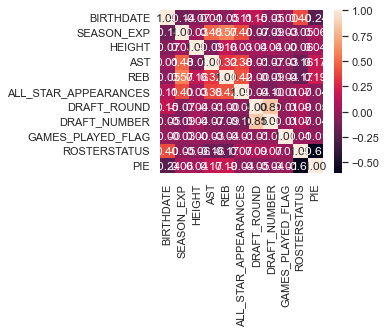

In [27]:
correlation_map = np.corrcoef(data_train_ft.values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=features, xticklabels=features)

plt.show()

### Step 6
Split the data into training and validation sets for use with cross-validation scoring. We split the data randomly to lower the chances of overfitting.

In [28]:
train_plus_validation_ftrs, test_ftrs, train_plus_validation_tgt, test_tgt = train_test_split (data_train_ft, data_train_tgt, test_size = 0.20,
                                   random_state = 42)

### Step 7
This is another portion where accuracy is most directly influenced. We added as many models as possible (within reason) to ensure that we were covering all our bases to get the most accurate predictions.

In [29]:

pipelines = \
    {
    'LR' : LinearRegression(),
    'CART' : DecisionTreeRegressor(max_depth=10)}
for k in range(1,32,2):
    pipelines[f'KNN-{k}'] = KNeighborsRegressor(n_neighbors=k)
for i in range(25,350,20):
    pipelines[f'GBR-{i}'] = GradientBoostingRegressor(random_state=21, n_estimators=i)
alpha_value=0.1
pipelines[f'Ridge (C={alpha_value})'] = linear_model.Ridge(alpha=alpha_value)
values = [0.25, 0.50, 0.75, 1.0, 1.25, 1.50, 1.75, 2.0, 3.0, 4.0, 5.0, 10, 20]
for alpha_value in values:
    pipelines[f'Lasso (C={alpha_value})'] = linear_model.Lasso(alpha=alpha_value)
print(pipelines)




{'LR': LinearRegression(), 'CART': DecisionTreeRegressor(max_depth=10), 'KNN-1': KNeighborsRegressor(n_neighbors=1), 'KNN-3': KNeighborsRegressor(n_neighbors=3), 'KNN-5': KNeighborsRegressor(), 'KNN-7': KNeighborsRegressor(n_neighbors=7), 'KNN-9': KNeighborsRegressor(n_neighbors=9), 'KNN-11': KNeighborsRegressor(n_neighbors=11), 'KNN-13': KNeighborsRegressor(n_neighbors=13), 'KNN-15': KNeighborsRegressor(n_neighbors=15), 'KNN-17': KNeighborsRegressor(n_neighbors=17), 'KNN-19': KNeighborsRegressor(n_neighbors=19), 'KNN-21': KNeighborsRegressor(n_neighbors=21), 'KNN-23': KNeighborsRegressor(n_neighbors=23), 'KNN-25': KNeighborsRegressor(n_neighbors=25), 'KNN-27': KNeighborsRegressor(n_neighbors=27), 'KNN-29': KNeighborsRegressor(n_neighbors=29), 'KNN-31': KNeighborsRegressor(n_neighbors=31), 'GBR-25': GradientBoostingRegressor(n_estimators=25, random_state=21), 'GBR-45': GradientBoostingRegressor(n_estimators=45, random_state=21), 'GBR-65': GradientBoostingRegressor(n_estimators=65, rand

### Step 8
Using different standardizing pipelines, run multiple cross-validation tests on the data splits to find the best performing model.

Further refine the selection of best model by comparing scores.

In [30]:

accuracy_scores = {}
for pipeline_name in pipelines:
    #loo = skms.LeaveOneOut()
    scores = skms.cross_val_score(pipelines[pipeline_name],
                                  train_plus_validation_ftrs,
                                  train_plus_validation_tgt,
                                  #cv=loo,
                                  cv=10,
                                  scoring='neg_mean_squared_error')
    scores = np.sqrt(-scores.mean())
    accuracy_scores[pipeline_name] = scores
    print(f'{pipeline_name}: {scores:.3f}')

best_model_name = min(accuracy_scores,key=accuracy_scores.get)
print(f'\nBest model: {best_model_name} (accuracy = {accuracy_scores[best_model_name]:.3f})')
final_model = pipelines[best_model_name]

## Best model sees to be GBR-85 (accuracy = 2.088)

LR: 2.762
CART: 2.549
KNN-1: 3.732
KNN-3: 3.100
KNN-5: 2.984
KNN-7: 2.996
KNN-9: 3.005
KNN-11: 3.026
KNN-13: 3.069
KNN-15: 3.103
KNN-17: 3.138
KNN-19: 3.174
KNN-21: 3.211
KNN-23: 3.221
KNN-25: 3.249
KNN-27: 3.264
KNN-29: 3.278
KNN-31: 3.295
GBR-25: 2.221
GBR-45: 2.111
GBR-65: 2.094
GBR-85: 2.088
GBR-105: 2.090
GBR-125: 2.093
GBR-145: 2.095
GBR-165: 2.097
GBR-185: 2.097
GBR-205: 2.100
GBR-225: 2.100
GBR-245: 2.102
GBR-265: 2.104
GBR-285: 2.107
GBR-305: 2.109
GBR-325: 2.113
GBR-345: 2.115
Ridge (C=0.1): 2.652
Lasso (C=0.25): 2.580
Lasso (C=0.5): 2.612
Lasso (C=0.75): 2.665
Lasso (C=1.0): 2.730
Lasso (C=1.25): 2.799
Lasso (C=1.5): 2.880
Lasso (C=1.75): 2.974
Lasso (C=2.0): 3.078
Lasso (C=3.0): 3.558
Lasso (C=4.0): 3.735
Lasso (C=5.0): 3.902
Lasso (C=10): 4.362
Lasso (C=20): 4.814

Best model: GBR-85 (accuracy = 2.088)


### Step 9
Rescale the data and fit the model.

In [31]:
scaler = StandardScaler().fit(train_plus_validation_ftrs)
rescaled_train_plus_validation_ftrs = scaler.transform(train_plus_validation_ftrs)
nba_scores_fit = final_model.fit(rescaled_train_plus_validation_ftrs, 
                                   train_plus_validation_tgt)

### Step 10
Scale the data and predict points on the selected model and save it in a temporary .csv for analysis.

In [32]:

rescaled_test_ftrs = scaler.transform(test_df)
predictions = nba_scores_fit.predict(rescaled_test_ftrs)
# score = np.sqrt(metrics.mean_squared_error(predictions, tes))
print(f'Using model: {final_model} and features: {features}')
# print(f'Final score: {score:.3f}')
# predictions = model.predict(rescaled_test_ftrs)

# compare = pd.DataFrame({'Prediction': predictions, 'Test Data' : test_tgt})
# compare.head(10)
# This is just using the test.csv to setup a dataframe of the correct size
# and indicies (the "id" field).
make_submission_df = pd.read_csv("test.csv")
# drop all columns except 'id'
make_submission_df = make_submission_df[['id']]
# make sure the column of ID's that we just read in is the index column
make_submission_df = make_submission_df.set_index('id')

Using model: GradientBoostingRegressor(n_estimators=85, random_state=21) and features: ['BIRTHDATE', 'SEASON_EXP', 'HEIGHT', 'AST', 'REB', 'ALL_STAR_APPEARANCES', 'DRAFT_ROUND', 'DRAFT_NUMBER', 'GAMES_PLAYED_FLAG', 'ROSTERSTATUS', 'PIE']


### Step 11
Add our predictions to a submission file and save the final .csv

In [33]:
make_submission_df['PTS'] = predictions
make_submission_df.to_csv('submission.csv',sep=',', float_format='%.2f')